# Logistic Regression Model

## Data Import And Cleaning

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc

In [10]:
# Helper functions

def add_target_column(data_frames, target_column='BGA-Phycocyanin RFU', 
                   new_target_name='bloom', threshold=2):
    for df in data_frames:
        df[new_target_name] = df[target_column].apply(
                                            lambda x: 1 if x > threshold else 0)

def import_df_data(files, drop_columns=[]):
    data_frames = []
    for file in files:
        df = pd.read_csv(file)
        for column in drop_columns:
            if column in df.columns:
                df = df.drop(columns=[column])
        data_frames.append(df)
    return data_frames

def train_model(training_df, testing_df, x_columns, y_column, max_iter=25000):
    """Trains a SGD Classifier model.

    training_df: dataframe of training data.
    testing_df: dataframe of testing data.
    x_columns: list of numerical feature column names.
    y_column: target string name.
        
    returns a tuple of:
    The trained model, predicted values, predicted probabilities, model accuracy
    """
    
    # Create training and testing numpy arrays
    x_train = training_df[x_columns].astype('float64').values
    x_test = testing_df[x_columns].astype('float64').values
    y_train = training_df[y_column].astype('float64').values
    y_test = testing_df[y_column].astype('float64').values
    
    # Scale the data
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    
    # Train the model
    model = SGDClassifier(max_iter=max_iter, loss="log")
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
#     predictions_prob = model.predict_proba(x_test)
    recall = recall_score(y_train, predictions)
    precision = precision_score(y_train, predictions)
    confusion_matrix = confusion_matrix(y_train, predictions)
#     accuracy = accuracy_score(y_test, predictions)
    return (recall, precision, confusion_matrix)

def roc_plot(actual, predictions):
    fpr, tpr, thresholds = roc_curve(actual, predictions)
    roc_auc = auc(fpr, tpr)
    plt.title("ROC")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.plot(fpr, tpr)

In [11]:
train_files = ['../../data/cleaned/utah_2017_vineyard.csv', 
               '../../data/cleaned/utah_2017_marina.csv',
               '../../data/cleaned/utah_2017_bird.csv']

test_files = ['../../data/cleaned/utah_2018_vineyard.csv', 
               '../../data/cleaned/utah_2018_marina.csv',
               '../../data/cleaned/utah_2018_bird.csv']

drop_columns = ['Time America/Boise UTC-06:00', 'Chlorophyll ug/L', 
                'Chlorophyll RFU', 'Wiper Pos V', 'Cable Pwr V', 'Battery V',
               'Date (mm.dd.yyyy)', 'Time 24hr', 'Chlorophyll (ug/L)', 
                'FDOM RFU']
x_columns = ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)',
            'ODOSat%', 'ODO (mg/L)']

train_dfs = import_df_data(train_files, drop_columns)
test_dfs = import_df_data(test_files, drop_columns)

train_dfs[0].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4
1,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4
2,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4
3,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4
4,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4


In [12]:
for df in train_dfs + test_dfs:
    print(df.columns)
    print(len(df.columns))

Index(['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)',
       'ODOSat%', 'ODO (mg/L)', 'BGA-Phycocyanin RFU'],
      dtype='object')
8
Index(['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)',
       'ODOSat%', 'ODO (mg/L)', 'BGA-Phycocyanin RFU'],
      dtype='object')
8
Index(['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)',
       'ODOSat%', 'ODO (mg/L)', 'BGA-Phycocyanin RFU'],
      dtype='object')
8
Index(['Temperature C', 'Sp Cond uS/cm', 'pH mV', 'pH', 'Turbidity NTU',
       'ODOSat %', 'ODO mg/L', 'BGA-Phycocyanin RFU'],
      dtype='object')
8
Index(['Temperature C', 'Sp Cond uS/cm', 'pH mV', 'pH', 'Turbidity NTU',
       'ODOSat %', 'ODO mg/L', 'BGA-Phycocyanin RFU'],
      dtype='object')
8
Index(['Temperature C', 'Sp Cond uS/cm', 'pH mV', 'pH', 'Turbidity NTU',
       'ODOSat %', 'ODO mg/L', 'BGA-Phycocyanin RFU'],
      dtype='object')
8


In [13]:
# Rename columns to be the same
for df in train_dfs + test_dfs:
    df.columns = x_columns + ['BGA-Phycocyanin RFU']
    print("New Columns:", df.columns)

New Columns: Index(['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)',
       'ODOSat%', 'ODO (mg/L)', 'BGA-Phycocyanin RFU'],
      dtype='object')
New Columns: Index(['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)',
       'ODOSat%', 'ODO (mg/L)', 'BGA-Phycocyanin RFU'],
      dtype='object')
New Columns: Index(['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)',
       'ODOSat%', 'ODO (mg/L)', 'BGA-Phycocyanin RFU'],
      dtype='object')
New Columns: Index(['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)',
       'ODOSat%', 'ODO (mg/L)', 'BGA-Phycocyanin RFU'],
      dtype='object')
New Columns: Index(['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)',
       'ODOSat%', 'ODO (mg/L)', 'BGA-Phycocyanin RFU'],
      dtype='object')
New Columns: Index(['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)',
       'ODOSat%', 'ODO (mg/L)', 'BGA-Phycocyanin RFU'],
      dtype='object')


In [14]:
add_target_column(train_dfs + test_dfs)

## BGA RFU Levels

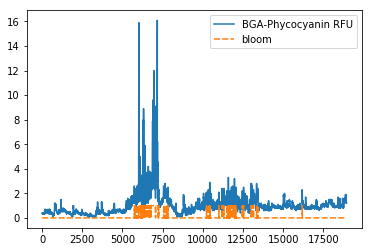

In [15]:
sns.lineplot(data=train_dfs[0][['BGA-Phycocyanin RFU', 'bloom']])

## Model Performance

In [8]:
avg_recall = 0
avg_precision = 0
for train in train_dfs:
    for test in test_dfs:
        recall, precision, cm = train_model(train, test, x_columns, 'bloom')
        avg_recall += recall
        avg_precision += precision
        print("Recall:", recall)
        print("Precision", precision)
        print("Confusion Matrix:\n", cm)
num_models = len(train_dfs) * len(test_dfs)
print("Average Recall:", avg_recall / num_models)
print("Average Precision:", avg_precision / num_models)

ValueError: Found input variables with inconsistent numbers of samples: [18947, 13812]